# Major and Minor Chord Classification
This project explores automatic guitar chord classification using convolutional neural networks (CNNs) applied to time-frequency spectrogram representations of audio signals. The model leverages chroma features, which capture the harmonic content of audio, and a 1D Convolutional Neural Network (CNN) to model temporal patterns in the chord sequences.

Two different datasets were combined for the purpose of this project. Both datasets contain labeled audio .wav files. It contains recordings of musical chords played on different instruments, where each audio file is labeled as either a major or minor chord. The dataset includes audio samples from both piano and guitar instruments.

Dataset: [Click here for link to dataset.](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification)

## Set-up (Package installation and Dependencies)

Run the cells below to install the necessary packages. This project relies on several Python libraries for audio processing, image generation, deep learning, and visualization. Before running the notebook, ensure all required packages are installed and available in your environment.

### Required Packages

* NumPy -  numerical computing and array operations

* Librosa -  audio loading, signal processing, and spectrogram generation

* TensorFlow / Keras - building, training, and evaluating the CNN model

* Sklearn - normalization and testing metrics

* OS / Glob / Shutil - file and directory management

In [22]:
!pip install sounddevice
!pip install librosa

In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import cv2
import os
from glob import glob
import librosa
!apt-get install -y libportaudio2
import sounddevice as sd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


## Split data into training, validation, and testing sets


In [24]:
import zipfile
import io
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  # Unzip the file
  with zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r') as zip_ref:
      zip_ref.extractall('/content/audio_files') # Extract to a specific folder
  print(f'User uploaded file "{fn}" and extracted.')


## Train, Validation, and Test Split

Train: 70%
Validation: 15%
Test: 15%

In [30]:
import os
import shutil
import random

random.seed(42)

BASE_DIR = "/content/audio_files"
DEST_DIR = "/content/audio_split"

CLASSES = ["Major", "Minor"]

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

assert TRAIN_RATIO + VAL_RATIO + TEST_RATIO == 1.0

for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

for cls in CLASSES:
    src_dir = os.path.join(BASE_DIR, cls)
    files = [f for f in os.listdir(src_dir) if f.endswith(".wav")]
    random.shuffle(files)

    n_total = len(files)
    n_train = int(n_total * TRAIN_RATIO)
    n_val = int(n_total * VAL_RATIO)

    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]

    for f in train_files:
        shutil.move(
            os.path.join(src_dir, f),
            os.path.join(DEST_DIR, "train", cls, f)
        )

    for f in val_files:
        shutil.move(
            os.path.join(src_dir, f),
            os.path.join(DEST_DIR, "val", cls, f)
        )

    for f in test_files:
        shutil.move(
            os.path.join(src_dir, f),
            os.path.join(DEST_DIR, "test", cls, f)
        )

    print(f"{cls}: train={len(train_files)}, val={len(val_files)}, test={len(test_files)}")



Major: train=0, val=0, test=0
Minor: train=0, val=0, test=0


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

shape = (256, 96)
batchSize = 64

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_dataset = train_gen.flow_from_directory(
    "/content/Spectorams.zip/Spectograms/train",
    target_size=shape,
    batch_size=batchSize,
    color_mode="grayscale",
    class_mode="binary",
    shuffle=True
)

validation_dataset = val_gen.flow_from_directory(
    "/content/Spectorams.zip/Spectograms/val",
    target_size=shape,
    batch_size=batchSize,
    color_mode="grayscale",
    class_mode="binary",
    shuffle=False
)

test_dataset = test_gen.flow_from_directory(
    "/content/Spectorams.zip/Spectograms/test",
    target_size=shape,
    batch_size=batchSize,
    color_mode="grayscale",
    class_mode="binary",
    shuffle=False
)

print(train_dataset)

Found 952 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


## Chroma Feature Extraction
Chroma features provide a compact representation of the harmonic content of an audio signal. They capture the intensity of each of the twelve semitone pitch classes present in a piece of music, while ignoring octave information. The extraction of chroma features begins with loading the raw audio waveform and converting it to a mono signal. The signal is then analyzed using a short-time Fourier transform (STFT), which divides the audio into overlapping frames and computes the frequency spectrum for each frame. For distinguishing major and minor chords, chroma features are ideal because different chords produce characteristic patterns across the twelve pitch classes.

In this project, we extract chroma features for each audio file using `librosa`. Each audio signal is analyzed with a Fourier transform using a window size of 2048 samples (`n_fft=2048`) and a hop length of 512 samples (`hop_length=512`) to compute overlapping frames. The resulting chroma matrix is transposed so that rows correspond to time frames and columns correspond to pitch classes. To ensure consistent input size for the convolutional neural network, each matrix is padded or truncated to a fixed number of frames (`MAX_FRAMES`). This allows the 1D CNN to effectively learn the temporal patterns of pitch intensities that differentiate major and minor chords.


In [27]:
DATA_ROOT = "/content/audio_split/"
SR = 22050
N_FFT = 2048
HOP_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 40
MAX_FRAMES = 130  # max time frames per audio


def extract_chroma(file_path):
    y, sr = librosa.load(file_path, sr=SR, mono=True)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH).T

    if chroma.shape[0] < MAX_FRAMES:
        pad_width = MAX_FRAMES - chroma.shape[0]
        chroma = np.pad(chroma, ((0,pad_width),(0,0)), mode='constant')
    else:
        chroma = chroma[:MAX_FRAMES, :]
    return chroma  # shape: (MAX_FRAMES, 12)

def load_dataset(split_dir):
    X, y = [], []
    for label, class_name in enumerate(["Major", "Minor"]):
        class_dir = os.path.join(split_dir, class_name)
        for fname in os.listdir(class_dir):
            if not fname.lower().endswith((".wav", ".mp3", ".flac")):
                continue
            file_path = os.path.join(class_dir, fname)
            try:
                features = extract_chroma(file_path)
                X.append(features)
                y.append(label)
            except Exception as e:
                print(f"Skipping {file_path}: {e}")
    return np.array(X), np.array(y)

X_train, y_train = load_dataset(os.path.join(DATA_ROOT, "train"))
X_val, y_val     = load_dataset(os.path.join(DATA_ROOT, "val"))
X_test, y_test   = load_dataset(os.path.join(DATA_ROOT, "test"))

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

scaler = StandardScaler()
# reshape to 2D for scaling
X_train_2d = X_train.reshape(-1, 12)
X_val_2d   = X_val.reshape(-1, 12)
X_test_2d  = X_test.reshape(-1, 12)

X_train_2d = scaler.fit_transform(X_train_2d)
X_val_2d   = scaler.transform(X_val_2d)
X_test_2d  = scaler.transform(X_test_2d)

# reshape back to 3D
X_train = X_train_2d.reshape(-1, MAX_FRAMES, 12)
X_val   = X_val_2d.reshape(-1, MAX_FRAMES, 12)
X_test  = X_test_2d.reshape(-1, MAX_FRAMES, 12)

Train: (952, 130, 12) (952,)
Val:   (203, 130, 12) (203,)
Test:  (206, 130, 12) (206,)


## 1D Convolutional Neural Network for Chroma Features

To capture the patterns and temporal dependencies in these sequences, a one-dimensional convolutional neural network (1D CNN) is applied. A 1D CNN can learn spatially local patterns along the time axis, such as the characteristic progression of pitch intensities in major versus minor chords.

### 1D CNN Architecture for Chroma Features

- **Input Layer:** Chroma feature matrix of shape `(MAX_FRAMES, 12)`  
- **Conv1D Layer 1:** 32 filters, kernel size 3, ReLU activation  
- **MaxPooling1D Layer 1:** Pool size 2  

- **Conv1D Layer 2:** 64 filters, kernel size 3, ReLU activation  
- **MaxPooling1D Layer 2:** Pool size 2  
- **Conv1D Layer 3:** 128 filters, kernel size 3, ReLU activation  
- **MaxPooling1D Layer 3:** Pool size 2  
- **GlobalAveragePooling1D:** Reduces each feature map to a single value  
- **Dense Layer 1:** 32 units, ReLU activation  
- **Dropout Layer:** 30% dropout to reduce overfitting  
- **Output Layer:** 1 unit, Sigmoid activation for binary classification (Major vs Minor)

### Hyperparameters:

- **Batch Size:** 32  
- **Epochs:** 40  
- **Learning Rate:** 0.001 (Adam optimizer)  
- **Dropout Rate:** 0.3  


This architecture allows the model to learn both short-term and longer-term harmonic relationships in a computationally efficient way, making it well-suited for chord classification.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 128, 32)        │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 62, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 29, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,257 (141.63 KB)

 Trainable params: 36,257 (141.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5392 - auc: 0.4909 - loss: 0.6997 - val_accuracy: 0.5616 - val_auc: 0.6025 - val_loss: 0.6769
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6070 - auc: 0.6192 - loss: 0.6677 - val_accuracy: 0.5567 - val_auc: 0.6236 - val_loss: 0.6802
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6240 - auc: 0.6558 - loss: 0.6561 - val_accuracy: 0.5714 - val_auc: 0.6267 - val_loss: 0.6754
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6552 - auc: 0.7411 - loss: 0.6233 - val_accuracy: 0.5961 - val_auc: 0.6273 - val_loss: 0.6582
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6640 - auc: 0.7148 - loss: 0.6167 - val_accuracy: 0.6207 - val_auc: 0.6717 - val_loss: 0.6509
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6712 - auc: 0.7336 - loss: 0.6090 - val_accuracy: 0.6355 - val_auc: 0.6933 - val_loss: 0.6406
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/

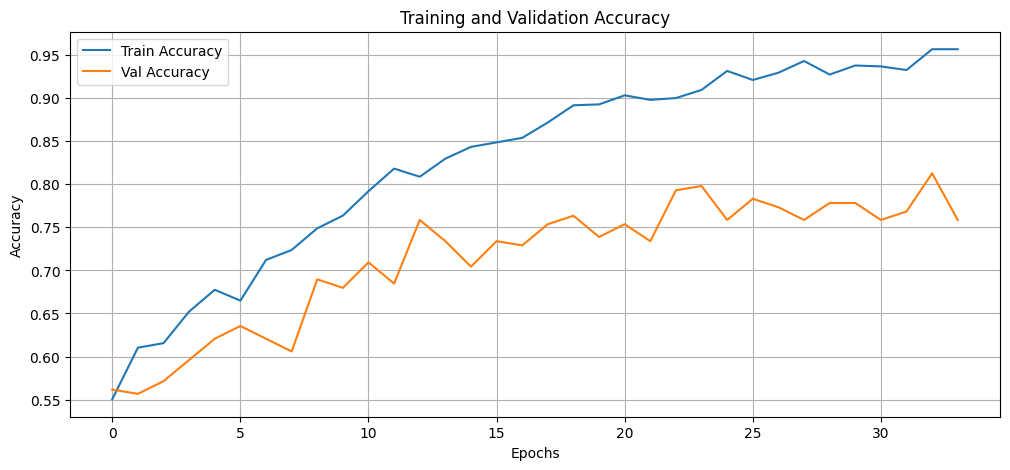

In [36]:
model = keras.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(MAX_FRAMES, 12)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        patience=10,
        restore_best_weights=True,
        mode="max"
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

import matplotlib.pyplot as plt

def plot_training(history):
    # Accuracy
    plt.figure(figsize=(12,5))

    plt.subplot(1,1,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training(history)




## Evaluation

In [37]:

test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.3f}")
print(f"Test AUC:      {test_auc:.3f}")

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Major", "Minor"]))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7773 - auc: 0.5300 - loss: 0.6121    

Test Accuracy: 0.767
Test AUC:      0.839
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Confusion Matrix:
[[88 26]
 [22 70]]

Classification Report:
              precision    recall  f1-score   support

       Major       0.80      0.77      0.79       114
       Minor       0.73      0.76      0.74        92

    accuracy                           0.77       206
   macro avg       0.76      0.77      0.77       206
weighted avg       0.77      0.77      0.77       206



## Results

The 1D CNN trained on chroma features achieved a test accuracy of 76.7% and a test AUC of 0.839, indicating that the model is performing well at distinguishing major from minor chords. The confusion matrix shows that most misclassifications are fairly balanced, with 26 major chords incorrectly predicted as minor and 22 minor chords predicted as major. The classification report further confirms this balance, with the Major class achieving a precision of 0.80 and recall of 0.77, and the Minor class achieving a precision of 0.73 and recall of 0.76. Overall, the macro-averaged F1-score of 0.77 reflects good generalization across both classes, suggesting that the model effectively captures the harmonic patterns in the chroma features despite the limited dataset size.


## Next steps
Regarding next steps, I plan to move beyond classifying chords as simply Major or Minor and instead to predict the specific chord names, such as C major, A minor, G# major, etc. This will require expanding the dataset to include a wider variety of chords and their inversions, as well as potentially incorporating additional audio features to capture more nuanced harmonic information. On the modeling side, the architecture could be enhanced with multi-class classification layers and more sophisticated sequence models.
